### Mary Adkisson, Calen Kimmell, and Bethanie Williams
### CSC 5220 Final Project: Malware Detection
### Neural Networks and Support Vector Machine
### November 23, 2020

###############################################################################################################################

## Step 1: Import Libraries

In [1]:
# Import libraries
            
import scipy
import numpy
import pandas
import seaborn as sb
%matplotlib inline
from pandas import read_csv
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

# Other machine learning modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score 
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score
from sklearn.svm import SVC

Using TensorFlow backend.


## Step 2: Import dataset

In [2]:
# We need to get rid of the md5 hash that since it is a string and all the other features are floats
file_name = 'Kaggle-data.csv'
# When I originally did it there was one extra col that just had nan values so i removed the last one
num_cols = range(0,57)
dataset = read_csv(file_name, header = 0, usecols = num_cols)
# Dropped the md5 hash column 
dataset = dataset.drop(['md5'], axis=1)
# Get the y values into a separate dataframe
y_vals = dataset.legitimate
# shows us the number of instances (rows) that belong to each class
print(dataset.groupby('legitimate').size())  
# Drop the y values from the original dataframe 
dataset = dataset.drop(['legitimate'], axis=1)

# 0 means malware, 1 means benign

legitimate
0    140849
1     75503
dtype: int64


## Step 3: Statistical Summary of Dataset

In [3]:
dataset.describe()

,ID,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,...,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
count,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,...,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000
mean,108176.500000,3280.509836,225.389698,4658.171110,8.899400,4.298070,3.953873e+05,5.827983e+05,1.332423e+06,2.812214e+05,...,24.093205,21.311862,3.758008,2.391040,5.149422,9.997023e+04,7.139623e+04,2.524535e+05,1.023401e+06,7.888492
std,62455.587057,9579.758901,4.554221,7844.088893,5.825682,11.965366,1.962775e+07,2.841106e+07,7.337809e+07,1.254327e+07,...,267.169003,130.677344,1.270336,1.042123,1.864446,1.718201e+07,1.681531e+07,2.433613e+07,4.772522e+07,8.049384
min,1.000000,332.000000,176.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,54088.750000,332.000000,224.000000,258.000000,7.000000,0.000000,2.560000e+04,1.536000e+04,0.000000e+00,1.253800e+04,...,0.000000,2.000000,3.362966,2.010121,3.594461,7.755000e+02,3.800000e+01,9.680000e+02,0.000000e+00,0.000000
50%,108176.500000,332.000000,224.000000,271.000000,9.000000,0.000000,1.018880e+05,1.198080e+05,0.000000e+00,4.661750e+04,...,0.000000,6.000000,3.671986,2.458492,5.217124,1.601958e+03,4.800000e+01,7.336000e+03,0.000000e+00,0.000000
75%,162264.250000,332.000000,224.000000,8450.000000,10.000000,0.000000,1.228800e+05,3.850240e+05,0.000000e+00,7.618000e+04,...,0.000000,13.000000,4.194799,3.003092,6.122045,3.146400e+03,2.320000e+02,1.700500e+04,7.200000e+01,15.000000
max,216352.000000,43620.000000,352.000000,49551.000000,255.000000,255.000000,4.294967e+09,4.294967e+09,4.294967e+09,4.127916e+09,...,23986.000000,8215.000000,7.999723,7.999723,8.000000,4.294903e+09,4.294903e+09,4.294903e+09,4.294967e+09,26.000000


## Step 4: Pairwise Correlation of Features

In [4]:
dataset.corr()

,ID,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,...,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
ID,1.000000,-0.089709,-0.089104,-0.126395,-0.090089,0.015375,-0.007938,-0.002004,-0.013192,-0.007222,...,-0.048101,-0.028025,0.250975,-0.075881,0.335122,-0.000788,-0.001749,0.002856,-0.007060,0.511307
Machine,-0.089709,1.000000,0.987403,0.072265,0.030861,-0.084950,0.000696,-0.002533,-0.005585,0.004129,...,0.043856,0.043193,-0.023421,0.101036,-0.079459,-0.001601,-0.001298,-0.002483,-0.006600,0.231100
SizeOfOptionalHeader,-0.089104,0.987403,1.000000,0.071759,0.039354,-0.076531,0.070873,0.049669,-0.005536,0.004061,...,0.043219,0.042508,-0.024565,0.098774,-0.079658,-0.001587,-0.001287,-0.002463,-0.006543,0.227293
Characteristics,-0.126395,0.072265,0.071759,1.000000,-0.215463,0.350597,0.006158,0.000895,-0.006256,0.012908,...,0.030852,0.087474,-0.046706,-0.013781,-0.077261,-0.002910,-0.002365,-0.003526,-0.005389,0.020352
MajorLinkerVersion,-0.090089,0.030861,0.039354,-0.215463,1.000000,-0.222075,0.048212,0.032241,0.007368,-0.003785,...,-0.003019,-0.020986,0.071237,0.140788,0.022779,-0.000004,0.000196,-0.000483,0.016880,-0.027587
MinorLinkerVersion,0.015375,-0.084950,-0.076531,0.350597,-0.222075,1.000000,0.049020,0.021031,0.024871,0.008945,...,-0.012140,0.011396,-0.038857,-0.076242,-0.028155,-0.001468,-0.001460,-0.000527,-0.000989,-0.190963
SizeOfCode,-0.007938,0.000696,0.070873,0.006158,0.048212,0.049020,1.000000,0.320853,0.134945,0.001284,...,0.006128,0.004996,-0.005500,-0.004692,-0.003430,0.000245,0.000268,0.000164,-0.000263,-0.006280
SizeOfInitializedData,-0.002004,-0.002533,0.049669,0.000895,0.032241,0.021031,0.320853,1.000000,0.097395,0.001307,...,0.001146,0.010827,-0.002709,-0.007036,0.001968,-0.000007,-0.000060,0.001065,-0.000326,-0.006692
SizeOfUninitializedData,-0.013192,-0.005585,-0.005536,-0.006256,0.007368,0.024871,0.134945,0.097395,1.000000,0.000690,...,-0.001619,-0.001419,-0.001735,-0.007986,0.006992,-0.000082,-0.000063,-0.000109,-0.000386,-0.017376
AddressOfEntryPoint,-0.007222,0.004129,0.004061,0.012908,-0.003785,0.008945,0.001284,0.001307,0.000690,1.000000,...,0.005526,0.003712,-0.002294,-0.011891,0.000981,-0.000031,-0.000018,0.000295,-0.000178,-0.007810


Text(0.5, 1, 'Correlation between different features:')

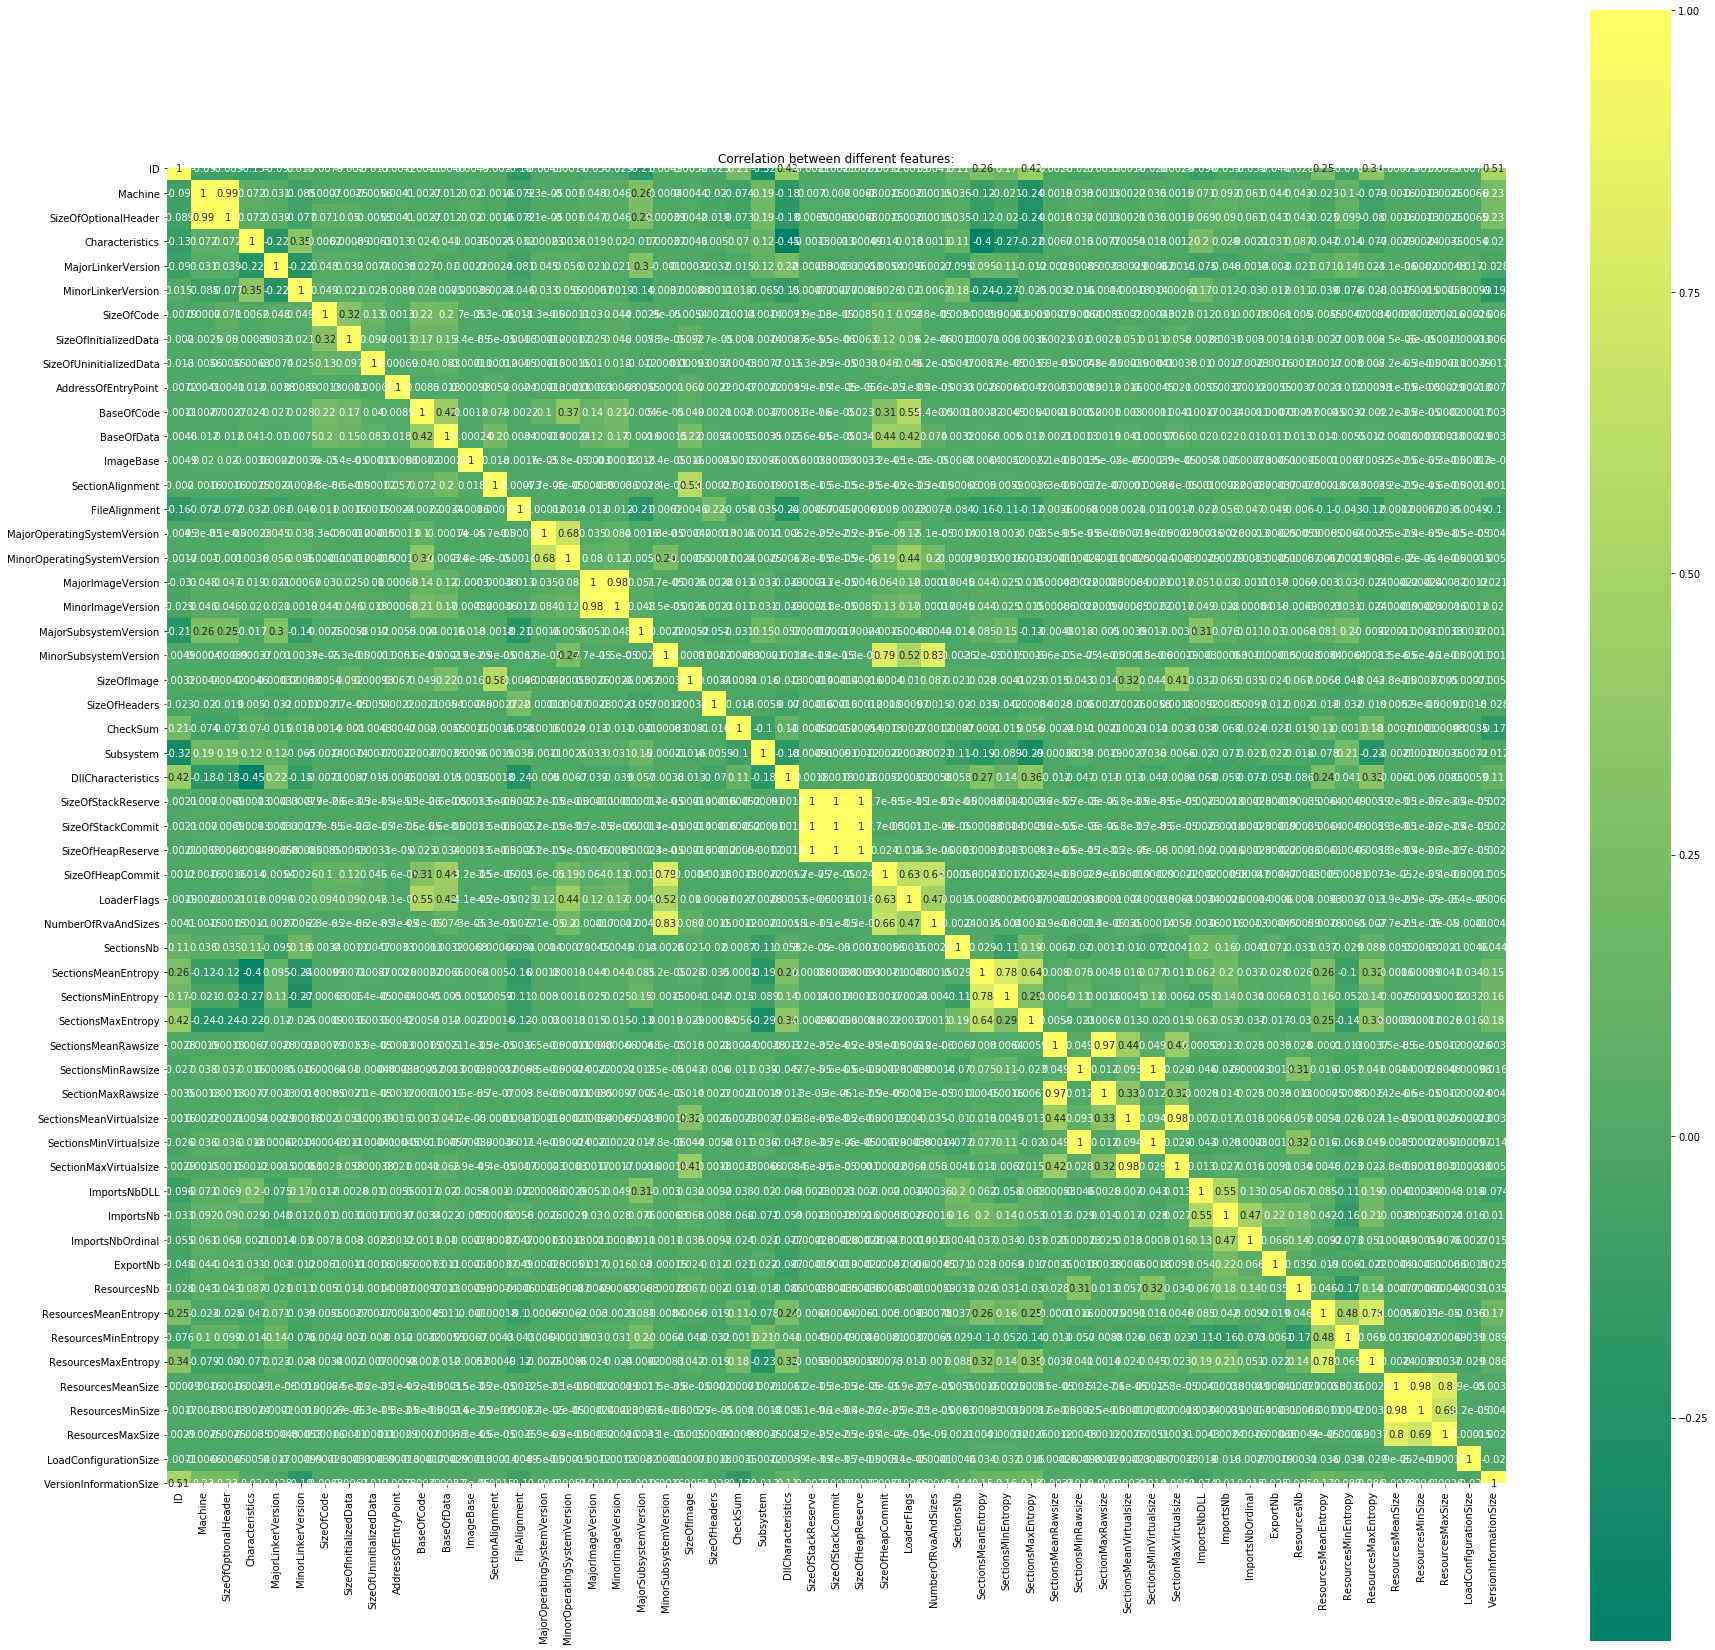

In [5]:
correlation = dataset.corr()
pyplot.figure(figsize = (30, 30))
sb.heatmap(correlation, vmax = 1, square = True, annot = True, cmap = 'summer')

pyplot.title('Correlation between different features:')

## Step 5: Normalizing and Splitting Data

In [6]:
# Store X and Y vals
X_vals = dataset.iloc[:,:].values #
y_vals = y_vals.values

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler.fit(X_vals))
MinMaxScaler()
max_data = scaler.data_max_
norm_data = scaler.transform(X_vals)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [8]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(norm_data, y_vals, test_size = 0.2, random_state = 0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print("X-Train Shape:", X_train.shape)
print("X-Test Shape:", X_test.shape)
# print("X-val Shape:", X_val.shape)
print("y train Shape:", y_train.shape)
print("y test shape:", y_test.shape)
# print("y val shape:", y_val.shape)

X-Train Shape: (173081, 55)
X-Test Shape: (43271, 55)
y train Shape: (173081,)
y test shape: (43271,)


## Step 6: One-Hot Encoding 

In [9]:
# One-Hot Encoding
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)
print(y_train.shape)

(173081, 2)


## Step 7: Neural Network Model 

In [10]:
# Build model with 2 hidden layers
model = Sequential()
model.add(Dense(32, input_dim=55, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
opt = SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
tic = time.perf_counter()
history = model.fit(X_train,y_train,epochs=10,batch_size=100)
toc = time.perf_counter()
print(f"Time to train: {toc - tic:0.4f} seconds")

Epoch 1/10
173081/173081 [==============================] - 6s 37us/step - loss: 0.6477 - accuracy: 0.6512
Epoch 2/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.2677 - accuracy: 0.8665
Epoch 3/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.0486 - accuracy: 0.9861
Epoch 4/10
173081/173081 [==============================] - 5s 26us/step - loss: 0.0434 - accuracy: 0.9879
Epoch 5/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.0391 - accuracy: 0.9891
Epoch 6/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.0323 - accuracy: 0.9919
Epoch 7/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.0283 - accuracy: 0.9931
Epoch 8/10
173081/173081 [==============================] - 5s 26us/step - loss: 0.0257 - accuracy: 0.9935
Epoch 9/10
173081/173081 [==============================] - 4s 25us/step - loss: 0.0229 - accuracy: 0.9940
Epoch 10/10
173081/173081 [==========

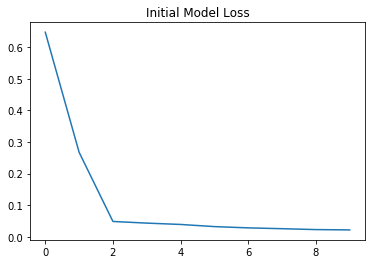

In [11]:
plt.plot(history.history['loss'])
plt.title('Initial Model Loss')
plt.show()

## Step 8: Hyper Parameter Optimzation

In [12]:
def tuned_model(L=1, N=32, a_h='sigmoid', a_o='softmax'):
    model = Sequential()
    model.add(Dense(N, input_dim=55, kernel_initializer='normal', activation=a_h))
    for i in range(L):
        model.add(Dense(N, kernel_initializer='normal', activation=a_h))
    model.add(Dense(2, kernel_initializer='normal', activation=a_o))
    opt = SGD(lr=0.01,momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
predictor = KerasClassifier(build_fn=tuned_model, epochs=10, batch_size=100, verbose=0)

In [ ]:
# Perform hyper-parameter optimization 
layers = [1,2,3,4,5]
neurons = [32,64,128]
a_h = ['sigmoid', 'relu']
a_o = ['sigmoid', 'softmax']
param_grid = dict(L=layers, N=neurons, a_h=a_h, a_o=a_o)
grid = GridSearchCV(estimator=predictor, param_grid=param_grid, n_jobs=1, cv=3)
tic = time.perf_counter()
grid_result = grid.fit(X_train, y_train) #Use validation set obtained by kfold split
toc = time.perf_counter()
print(f"Time to optimize: {toc - tic:0.4f} seconds")

In [ ]:
print('Best Hyper Parameters: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print('%f (%f) with: %r' % (mean, stdev, param))

## Step 9: Testing Optimal Model with Trained Data

In [ ]:
L = grid_result.best_params_['L']
N = grid_result.best_params_['N']
a_h = grid_result.best_params_['a_h']
a_o = grid_result.best_params_['a_o']
model = tuned_model(L, N, a_h, a_o)
history = model.fit(X_train,y_train,epochs=10,batch_size=100)

In [ ]:
plt.plot(history.history['loss'])
plt.title('Optimized Model Loss')
plt.show()

In [ ]:
preds = model.predict(X_test)
preds = numpy.argmax(preds, axis=1)
# y_test = numpy.argmax(y_test, axis=1)

## Step 10: Print Model Scores

In [ ]:
# Plot scores and ROC/AUC Curve
fpr, tpr, _ = roc_curve(y_test, preds)
pyplot.plot(fpr, tpr, marker='.', color='purple', label='ROC curve (AUC = %0.3f)' % roc_auc_score(y_test, preds))
# axis labels
pyplot.title('ROC Curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print('Accuracy:',accuracy_score(y_train, preds))
print('Precision Score:', precision_score(y_train, preds))
print('Recall Score:', recall_score(y_train, preds))
print('F1 Score:', f1_score(y_train, preds))